# Исследование приложения Procrastinate Pro+

## Описание проекта

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. 
Задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
лог сервера с данными об их посещениях,
выгрузка их покупок за этот период,
рекламные расходы.

Необходимо изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.


В распоряжении три датасета. Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу.

1. Структура visits_info_short.csv:

- User Id — уникальный идентификатор пользователя,

- Region — страна пользователя,

- Device — тип устройства пользователя,

- Channel — идентификатор источника перехода,

- Session Start — дата и время начала сессии,

- Session End — дата и время окончания сессии.


2. Структура orders_info_short.csv:

- User Id — уникальный идентификатор пользователя,

- Event Dt — дата и время покупки,

- Revenue — сумма заказа.


3. Структура costs_info_short.csv:

- dt — дата проведения рекламной кампании,

- Channel — идентификатор рекламного источника,

- costs — расходы на эту кампанию.

## Загрузка данных и предобработка

In [1]:
#импортируем все необходимые библиотеки

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt 
import seaborn as sns

In [2]:
#загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные

visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),  # визиты
    pd.read_csv('/datasets/orders_info_short.csv'),  # заказы
    pd.read_csv('/datasets/costs_info_short.csv'),  # расходы
)

In [3]:
#выведем на экран первые 10 строк

visits.head(10)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
5,90242400005,United States,iPhone,RocketSuperAds,2019-05-01 07:14:52,2019-05-01 08:19:56
6,43958116050,United States,Android,organic,2019-05-01 09:03:21,2019-05-01 10:08:39
7,185365244969,United States,iPhone,organic,2019-05-01 09:37:03,2019-05-01 10:00:43
8,446013509831,United States,iPhone,RocketSuperAds,2019-05-01 10:26:00,2019-05-01 10:59:17
9,100970711362,United States,Mac,TipTop,2019-05-01 04:39:53,2019-05-01 04:57:05


In [4]:
#приведем название колонок к нижнему регистру

visits=visits.rename(columns = {'User Id':'user_id','Region':'region','Device':'device','Channel':'channel','Session Start':'session_start', 'Session End':'session_end'})

In [5]:
orders.head(10)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
5,129100331057,2019-05-01 01:56:28,4.99
6,626807144131,2019-05-01 02:39:21,4.99
7,914062168985,2019-05-01 02:02:18,4.99
8,769669137453,2019-05-01 03:39:47,4.99
9,434198630691,2019-05-01 18:16:50,5.99


In [6]:
orders=orders.rename(columns = {'User Id':'user_id','Event Dt':'event_dt','Revenue':'revenue'})

In [7]:
costs.head(10)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
5,2019-05-06,FaceBoom,118.8
6,2019-05-07,FaceBoom,101.2
7,2019-05-08,FaceBoom,100.1
8,2019-05-09,FaceBoom,93.5
9,2019-05-10,FaceBoom,104.5


In [8]:
costs=costs.rename(columns = {'Channel':'channel'})

На первый взгляд все хорошо. Выведем общую информацию о таблицах.

In [9]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [10]:
costs.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


В данных таблицах нет пропусков. Однако, в некоторых столбцах нужно преобразовать тип данных в datetime. Сделаем это в следующем шаге

In [12]:
# преобразование данных о времени
visits['session_start']=pd.to_datetime(visits['session_start'])
visits['session_end']=pd.to_datetime(visits['session_end'])
costs['dt']=pd.to_datetime(costs['dt']).dt.date
orders['event_dt']=pd.to_datetime(orders['event_dt'])

Проверим таблицы на наличие дубликатов.

In [13]:
visits.duplicated().sum()

0

In [14]:
costs.duplicated().sum()

0

In [15]:
orders.duplicated().sum()

0

Дубликатов в таблицах не обнаруженно.

На данном этапе были подготовленные данные для дальнейшего анализа. Проверили таблицы на наличие пропусков и дубликатов. Изменили типы данных в необходимых столбцах. А так же привели название столбцов к привичному формату.

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Соберём функции для создания профилей, расчёта удержания, конверсии, LTV и ROI:

In [16]:
# функция для создания пользовательских профилей

def get_profiles(visits, orders, costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [17]:
# функция для подсчёта Retention Rate

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [18]:
# функция для подсчёта конверсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [19]:
# функция для подсчёта LTV
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

А также функции для построения графиков:

In [20]:
# функция для сглаживания данных

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [21]:
# функция для построения графика Retention Rate
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке — динамика удержания платящих
    ax2 = plt.subplot(2, 2, 2)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [22]:
# функция для построения графика конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [23]:
# функция для визуализации LTV и ROI.

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

Таким образом было созданно функции для вычисления значений метрик:
    
- get_profiles() — для создания профилей пользователей,
- get_retention() — для подсчёта Retention Rate,
- get_conversion() — для подсчёта конверсии,
- get_ltv() — для подсчёта LTV.

А также функции для построения графиков:
- filter_data() — для сглаживания данных,
- plot_retention() — для построения графика Retention Rate,
- plot_conversion() — для построения графика конверсии,
- plot_ltv_roi — для визуализации LTV и ROI.

## Исследовательский анализ данных

Составим профили пользователей и определим минимальную и максимальную даты привлечения пользователей.

In [24]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Установим момент и горизонт анализа данных. 
Предположим, что на календаре 1 ноября 2019 года, и зададим двухнедельный горизонт анализа.

In [25]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

Определим минимальную и максимальную даты привлечения пользователей.


In [26]:
#минималльная дата 
min_date =profiles.first_ts.min()
min_date

Timestamp('2019-05-01 00:00:41')

In [27]:
#максималльная дата 
max_date = profiles.first_ts.max()
max_date

Timestamp('2019-10-27 23:59:04')

Минимальная дата привлечения пользователей из таблицы профилей 1 мая 2019 года, максимальная 27 октября 2019 года. Данные о привлечении пользователей соответствуют ТЗ заказчика.

Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [28]:
profiles.groupby('region').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})

user_id payer          
              nunique   sum      mean
region                               
France          17450   663  0.037994
Germany         14981   616  0.041119
UK              17575   700  0.039829
United States  100002  6902  0.069019

По созданной таблице видно, что больше всего пользователей в США, там же большего всего  платящих. А меньше всего в Германии.

Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [29]:
devices = profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'sum'})
devices['ratio'] = round(devices['payer'] / devices['user_id'], 3)
devices.rename(columns = {'user_id':'user_total', 'payer':'payer_total'}, inplace = True )
devices

,user_total,payer_total,ratio
device,,,
Android,35032,2050,0.059
Mac,30042,1912,0.064
PC,30455,1537,0.050
iPhone,54479,3382,0.062


Больше всего пользователи предпочитают iPhone. А вот Mac предпочитают меньше всего.Наибольшая доля платящих пользователей приходится на пользователей использующих приложение на Mac, меньше всего платящих у PC 

Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [30]:
channels = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'sum'})
channels['ratio'] = round(channels['payer']/channels['user_id'],3)
channels.rename(columns = {'user_id':'user_total', 'payer':'payer_total'}, inplace = True )
channels.sort_values('ratio', ascending = False)

,user_total,payer_total,ratio
channel,,,
FaceBoom,29144,3557,0.122
AdNonSense,3880,440,0.113
lambdaMediaAds,2149,225,0.105
TipTop,19561,1878,0.096
RocketSuperAds,4448,352,0.079
WahooNetBanner,8553,453,0.053
YRabbit,4312,165,0.038
MediaTornado,4364,156,0.036
LeapBob,8553,262,0.031


Как видим по сводной таблице, больше всего пользователей пришли без каких-либо источников привлечения (organic). Меньше всего приходят людей от lambdaMediaAds, но при этом на их долю приходится неплохой процент платящих. Наибольшая долю платящих от канала FaceBoom, наименьшая organic. 

По условию задачи мы анализуруем период с 1 мая по 27 октября 2019 года. Моментом анализа взяли 1 ноября 2019 года и задали двухнедельный горизонт анализа. Для анализа мы рассматриваем четыре страны пользователей: США, Германия, Великобритания и Франция. Создав сводную таблицу было обнаруженно, что больше всего пользователей в США, там же большего всего платящих. А меньше всего в Германии. Пользователи предпочитают устройства iPhone. А вот Mac предпочитают меньше всего. Наибольшая доля платящих пользователей приходится на пользователей использующих приложение на Mac, меньше всего платящих у PC. Так же анализ показал, что  больше всего пользователей пришли без каких-либо источников привлечения (organic). Меньше всего приходят людей от lambdaMediaAds, но при этом на их долю приходится неплохой процент платящих. Наибольшая доля платящих от канала FaceBoom, наименьшая organic. 

## Маркетинг

Посчитаем общую сумму расходов на маркетинг.

In [31]:
costs['costs'].sum().round(1)

105497.3

Общая сумма расходов на маркетинг составило 105497.3 млн.

Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [32]:
channel_costs = costs.groupby('channel')['costs'].agg('sum').sort_values(ascending = False)
channel_costs

channel
TipTop                54751.30
FaceBoom              32445.60
WahooNetBanner         5151.00
AdNonSense             3911.25
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
LeapBob                1797.60
lambdaMediaAds         1557.60
MediaTornado            954.48
YRabbit                 944.22
Name: costs, dtype: float64

Больше всего трат у канала TipTop, FaceBoom  и WahooNetBanner

Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.

Чтобы построить визуализацию динамики изменения расходов во времени по неделям и месяцам, сначала необходимо добавить в таблицу costs столбцы с месяцами и неделями.

In [33]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs['month'] = costs['dt'].dt.month
costs['week'] = costs['dt'].dt.isocalendar().week
costs.head()

,dt,channel,costs,month,week
0,2019-05-01,FaceBoom,113.3,5,18
1,2019-05-02,FaceBoom,78.1,5,18
2,2019-05-03,FaceBoom,85.8,5,18
3,2019-05-04,FaceBoom,136.4,5,18
4,2019-05-05,FaceBoom,122.1,5,18


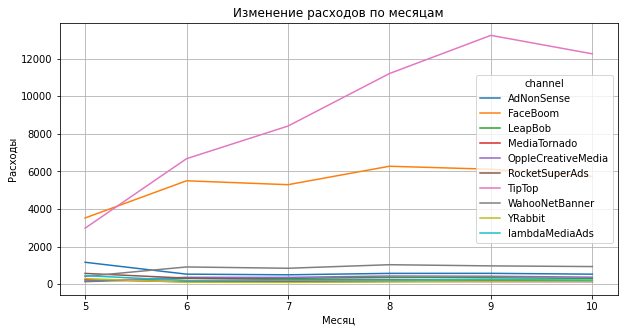

In [34]:
costs.pivot_table(
    index='month',   
    columns='channel', 
    values='costs',  
    aggfunc='sum',  
).plot(figsize=(10, 5), grid=True)

plt.title('Изменение расходов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.show()

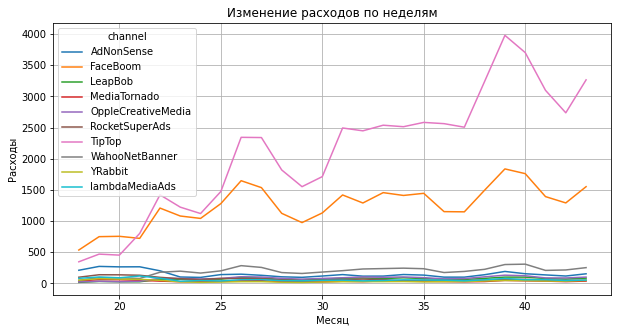

In [35]:
costs.pivot_table(
    index='week',   
    columns='channel', 
    values='costs',  
    aggfunc='sum',  
).plot(figsize=(10, 5), grid=True)

plt.title('Изменение расходов по неделям')
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.show()

Судя по графику, самые большие инвестиции на протяжении всего исследованного периода получает TipTop. На втором месте Faceboom - и это положительная новость, ведь он приносит лучшие конверсии и больше всего пользователей.

Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используем профили пользователей.

In [36]:
cac = profiles.groupby('channel')['acquisition_cost'].agg('mean').sort_values(ascending = False)
cac

channel
TipTop                2.799003
FaceBoom              1.113286
AdNonSense            1.008054
lambdaMediaAds        0.724802
WahooNetBanner        0.602245
RocketSuperAds        0.412095
OppleCreativeMedia    0.250000
YRabbit               0.218975
MediaTornado          0.218717
LeapBob               0.210172
organic               0.000000
Name: acquisition_cost, dtype: float64

In [37]:
cac.mean().round(2) #CAC по всему проекту

0.69

In [38]:
profiles.query('channel != "organic"').acquisition_cost.mean().round(2) #CAC без organic 

1.13

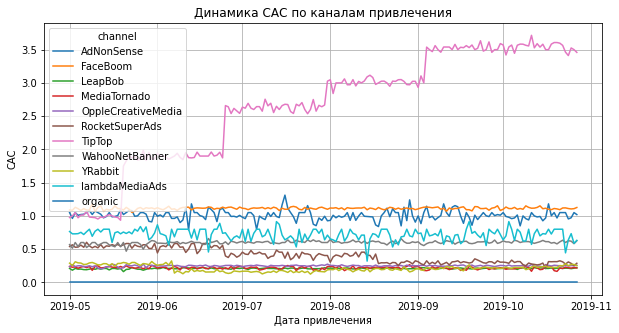

In [39]:
# строим график истории изменений CAC по каналам привлечения

profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Привлечение одного пользователя из всех рекламных сетей обошлось в среднем от 0,3 до 1,2 единиц. Если по большинству каналов расходы на протяжении всего времени были примерно равномерными, то TipTop на их фоне значительно выделяется, так как расходы на одного пользователя росли почти каждый месяц и он стал самой дорогой рекламной компанией.
Стоимость привлечения «органических» пользователей во всех когортах равна нулю, потому что они пришли самостоятельно, а не благодаря рекламе.
Средний CAC по всему проекту составил 0,69, а без органических пользователей - 1,13.

Таким образом общая сумма расходов на маркетинг составило 105497.3 млн. Больше всего трат у канала TipTop, FaceBoom и WahooNetBanner.

## Окупаемость рекламы

Для расчёта окупаемости рекламы исключим из исследуемого датафрейма пользователей, привлечённых органически: их данные никак не помогут понять окупаемость, но могут исказить статистику.

In [40]:
profiles = profiles.loc[profiles['channel'] != 'organic']

Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

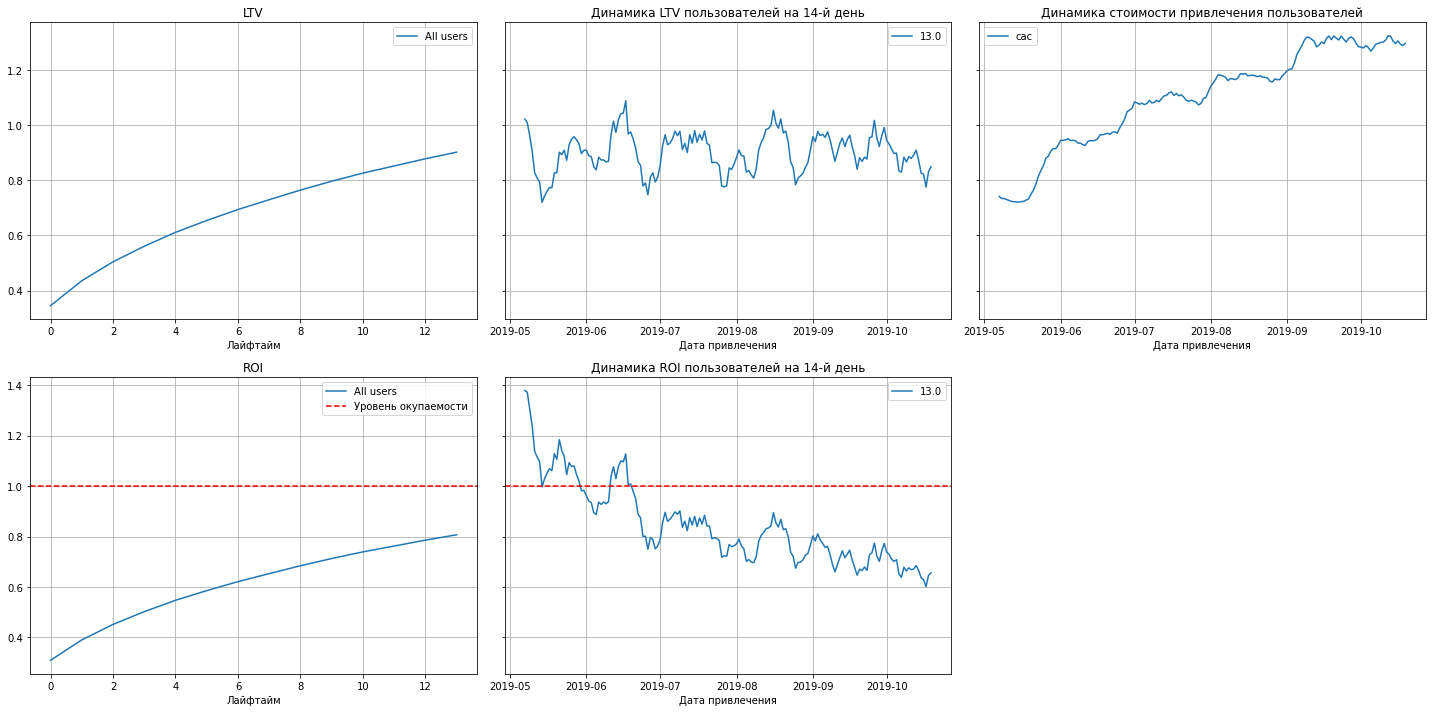

In [41]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По этим графикам можно сделать следующие выводы:

- Реклама не окупается. ROI в конце горизонта анализа едва достигает 80%.
- CAC постоянно растёт. Возможно, проблема в избыточном увеличении рекламного бюджета.
- LTV стабильно растёт, но без значительных скачков.

Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.

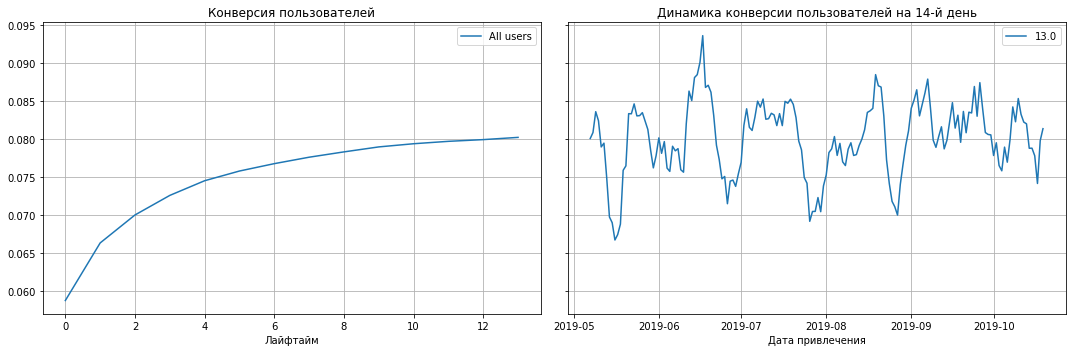

In [42]:
# смотрим конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

По графикам видим, что  конверсия имеет постоянную тенденцию к росту.

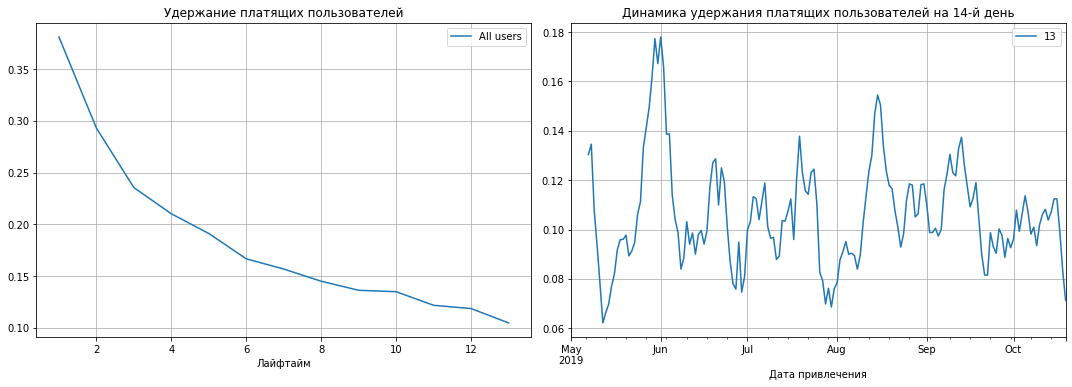

In [43]:
# смотрим удержание

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

На данных же графиках уже видим снижение динамики удержания пользователей. Чтобы понять, почему так происходит, изучим все характеристики пользователей.

Проанализируем окупаемость рекламы с разбивкой по устройствам.

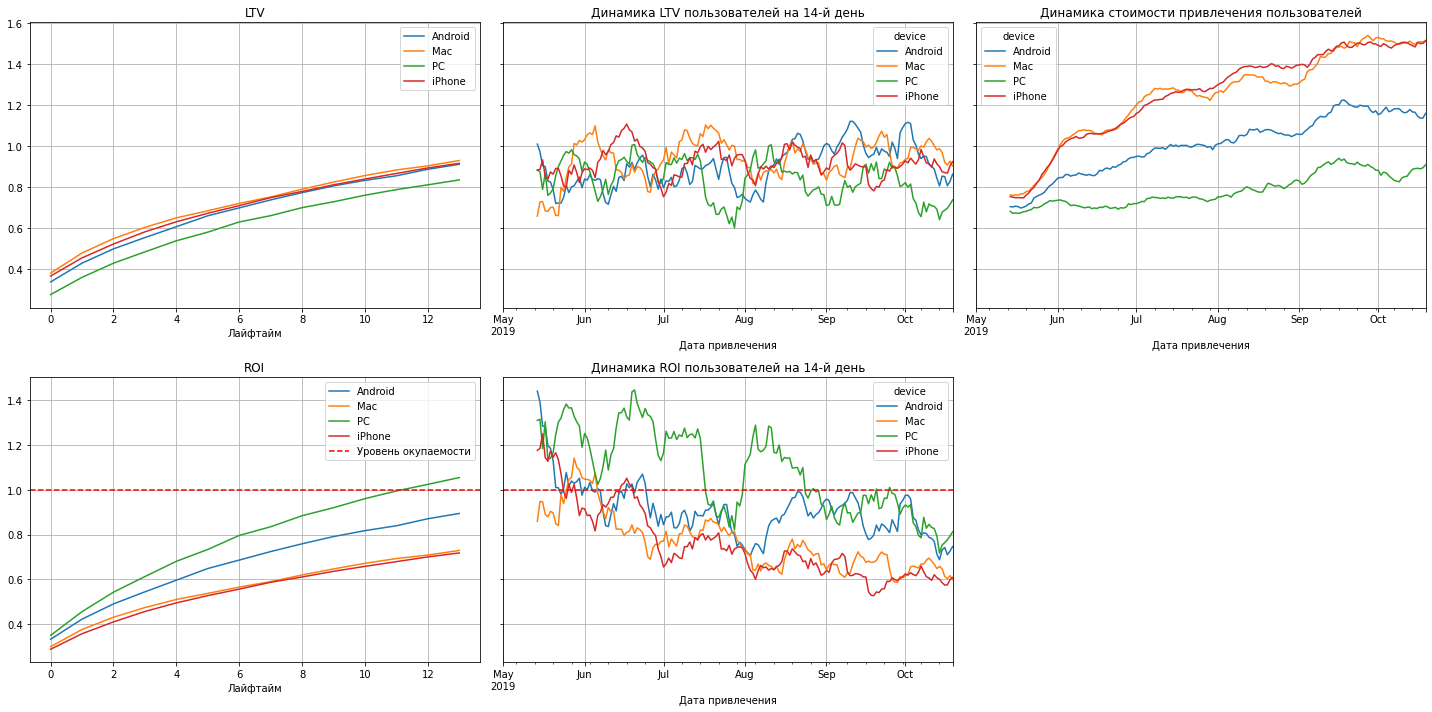

In [44]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

На графиках можно пронаблюдать, что пользователи использующие PC в качестве девайса для использования приложения окупаются в отличии пользователей с других устройств. Стоит отметить, что затраты на пользователей PC самые маленькие. Касаемо LTV можно проследить, что пользователи, пользующиеся приложением на PC потеницально потратят меньше средств чем пользователи, использующие приложение с других девайсов

Проанализируем окупаемость рекламы с разбивкой по странам. 

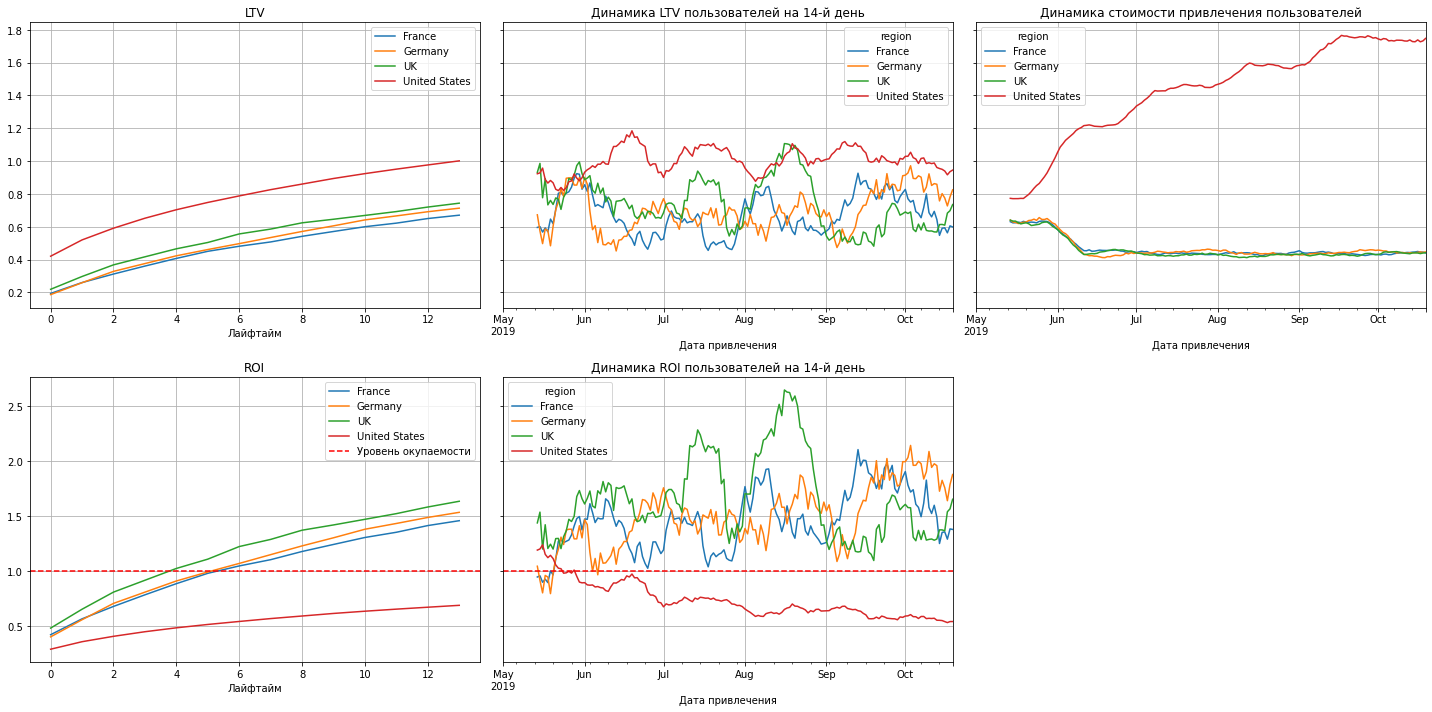

In [45]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Вот что говорят графики:
- Реклама окупается везде после 4 месяца, кроме США.
- Стоимость привлечения у США являлось самой высокой на протяжении всего периода.
- LTV стабилено растет.
- Лучше всего окупается Великобритания.

Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

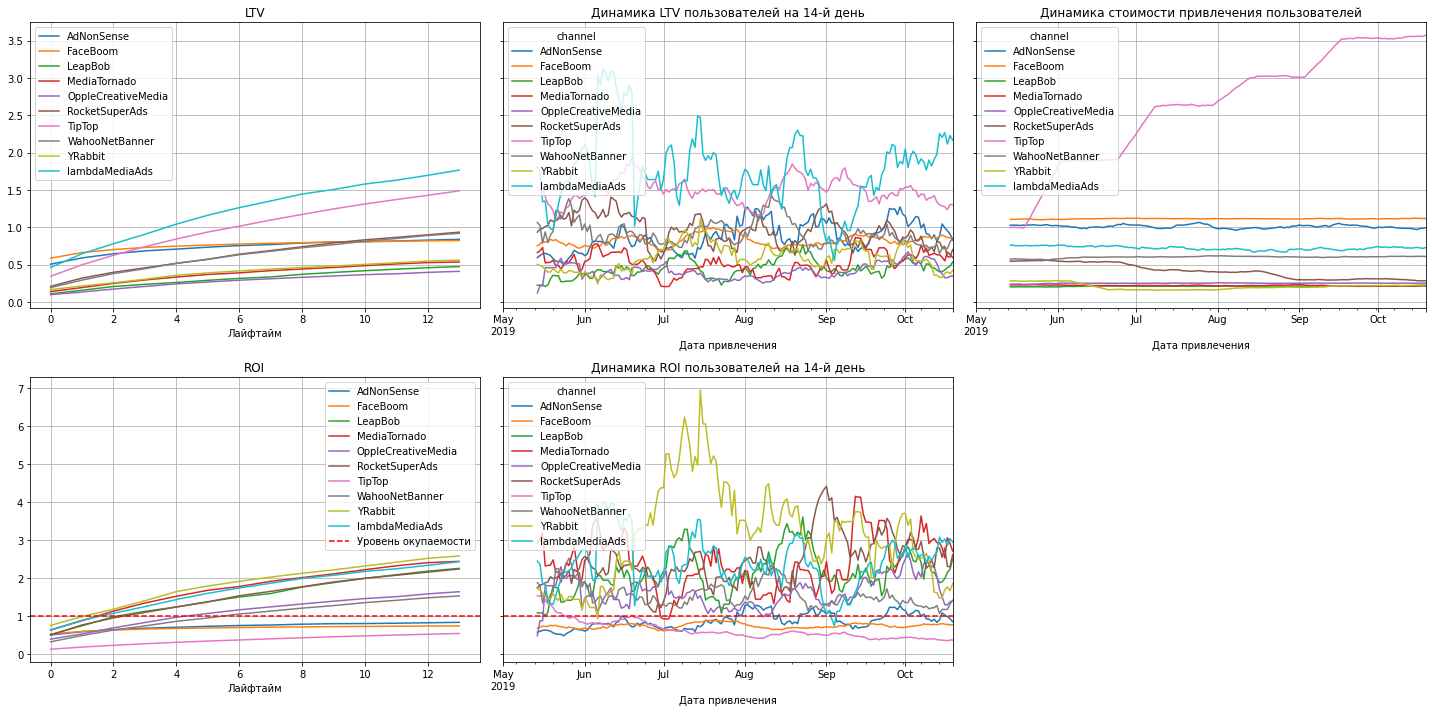

In [46]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Изучив графики видим, что самая высокая стоимость привлечения у канала TipTop - здесь стоимость привлечения пользователей стремительно растёт. Во всех остальных каналах стоимость привлечения стабильна.
По LTV уверенно лидирует LambdaMediaAds и в общем рассмотрении, и на 14 день
По ROI платформа TipTop находится ниже всех и даже не приближается к уровню окупаемости. Также проблемы наблюдаются с FaceBoom и AdNonSense.

Конверсия и удержание пользователей с разбивкой по устройствам

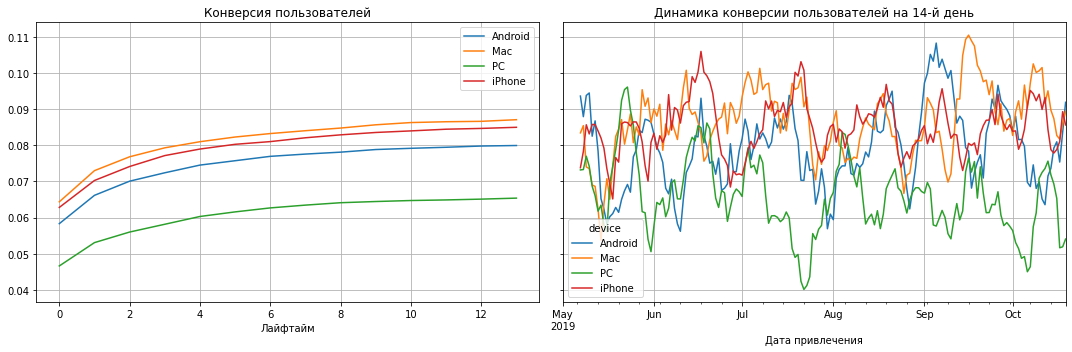

In [47]:
dimensions = ['device']
# конверсия с разбивкой по устройствам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = dimensions 
)
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Пользователи MAC и iPhone конвертируются лучше всего, в отличии от пользователей РС.

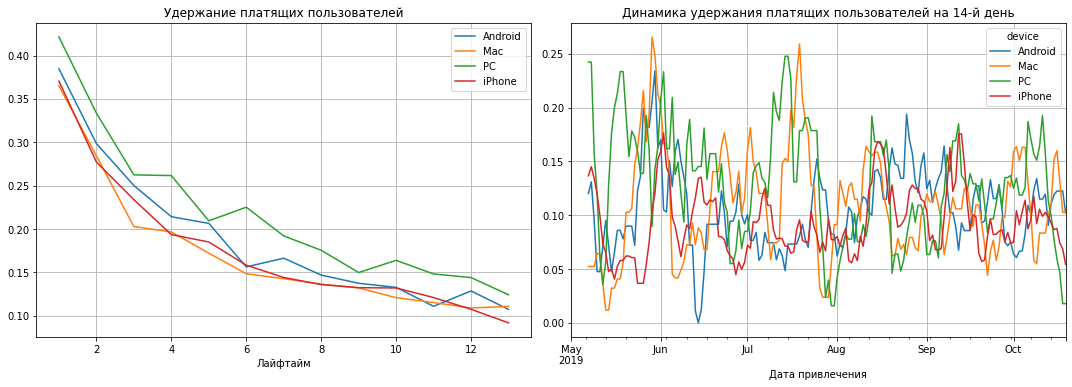

In [48]:
#удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Mac и iPhone удерживаются хуже всего. Возможно, это одна из причин низкой окупаемости.

Конверсия и удержание пользователей с разбивкой по странам

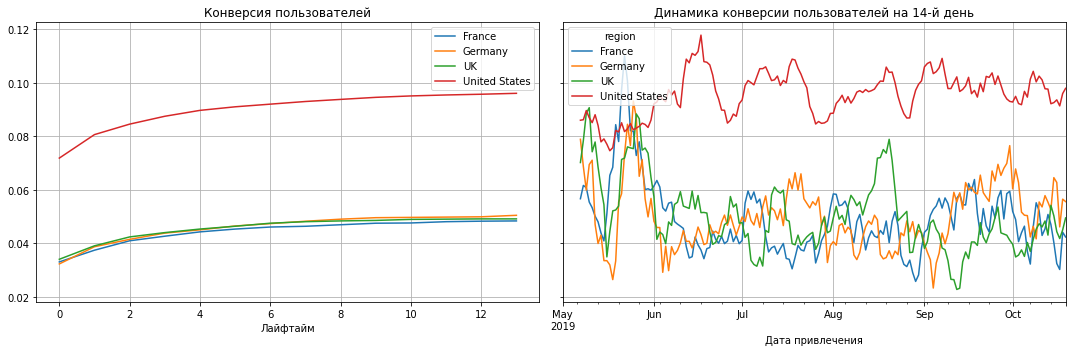

In [49]:
dimensions = ['region']
# конверсия с разбивкой по странам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = dimensions 
)
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

США вышел в лидеры по конверсии пользователей. Остальные примерно на одном уровне.

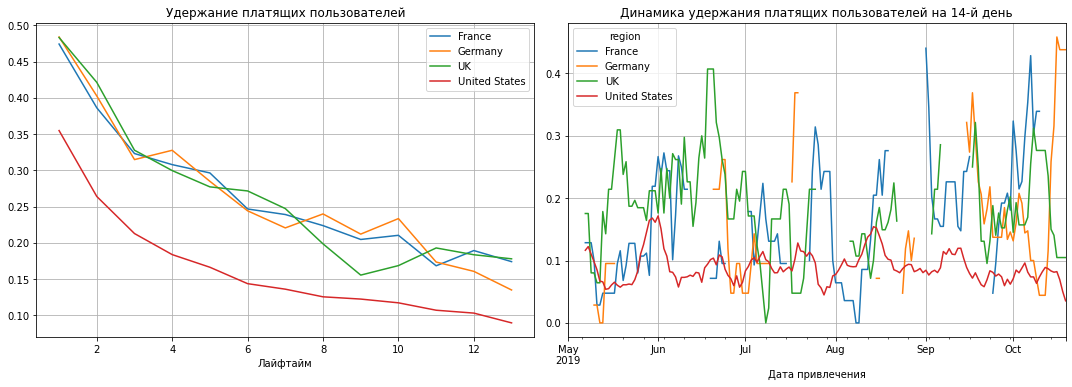

In [50]:
#удержание  с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

А вот удержание пользователей в США уже ниже чем у остальных.

Конверсия и удержание пользователей с разбивкой по каналам

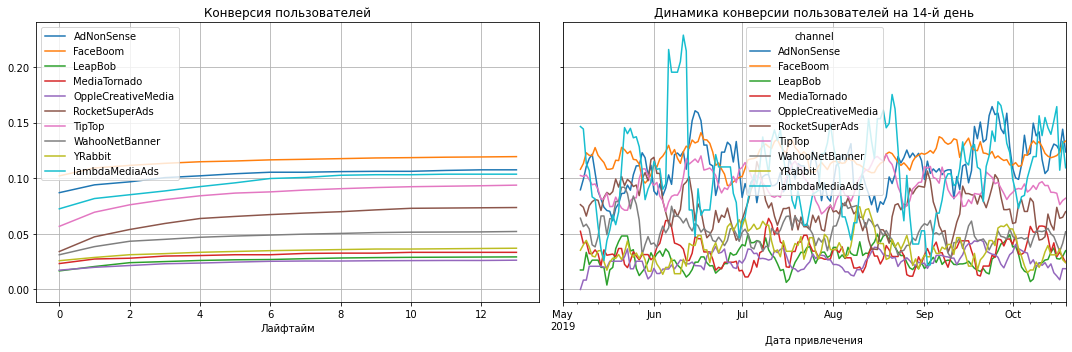

In [51]:
dimensions = ['channel']
# конверсия с разбивкой по каналам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = dimensions 
)
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам хорошая конверсия у канала FaceBoom и АdNonSense. 

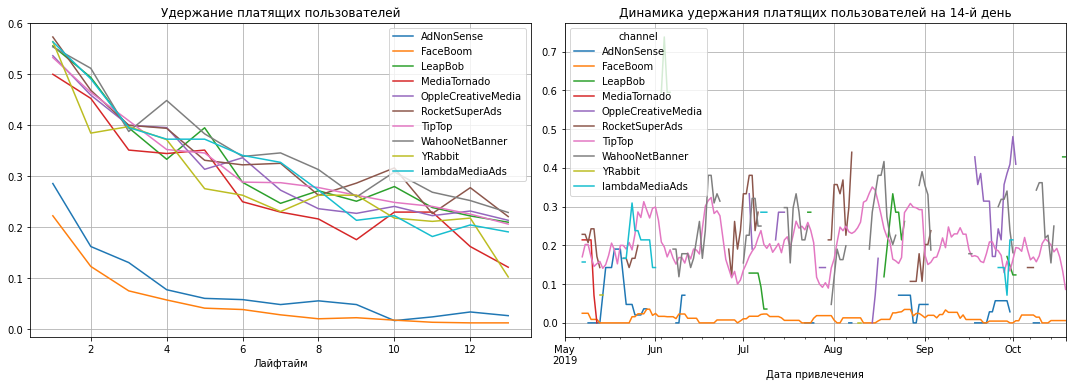

In [52]:
#удержание  с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание у наших лидеров по конверсии хуже чем в остальных каналах.

Пользователи mac и iphone удерживаются хуже всего. Возможно, это одна из причин низкой окупаемости.

В изначальном анализе по различным параметрам установлено, что:

- Реклама не окупается. ROI в конце периода едва достигает 80%.
- CAC постоянно растёт. Возможно, проблема в избыточном увеличении рекламного бюджета.
- LTV стабильно растёт, но без значительных скачков.

В детализированной разбивке выяснилось, что:

- Реклама имеет неплохую окупаемость во всех странах, кроме США. В этом регионе лучшая конверсия и худшее удержание.
- Mac и iPhone сильнее всего выросли в цене привлечения пользователя, и дальше всего от уровня окупаемости.
- Разбивка по каналам привлечения показывает, что у AdNonSense и FaceBoom очень низкое удержание платящих пользователей на 14 день. Значительно ниже, чем у других каналов привлечения.

Возможно, есть технические проблемы у пользователей из США. Необходимо проверить эту версию. Также нужно перепроверить рекламные кампании на каналах AdNonSense и Faceboom, и проверить, нормально ли работает приложение.

## Общий вывод
Была проделана большая работа по исследованию развлекательного приложения Procrastinate Pro+.

На первоначальном этапе были подготовленные данные для дальнейшего анализа. Проверили таблицы на наличие пропусков и дубликатов. Изменили типы данных в необходимых столбцах. А так же привели название столбцов к привичному формату.

Был созданно функции для вычисления значений метрик:
    
- get_profiles() — для создания профилей пользователей,
- get_retention() — для подсчёта Retention Rate,
- get_conversion() — для подсчёта конверсии,
- get_ltv() — для подсчёта LTV.

А также функции для построения графиков:
- filter_data() — для сглаживания данных,
- plot_retention() — для построения графика Retention Rate,
- plot_conversion() — для построения графика конверсии,
- plot_ltv_roi — для визуализации LTV и ROI.

По условию задачи мы анализуруем период с 1 мая по 27 октября 2019 года. Моментом анализа взяли 1 ноября 2019 года и задали двухнедельный горизонт анализа. Для анализа мы рассматриваем четыре страны пользователей: США, Германия, Великобритания и Франция. Создав сводную таблицу было обнаруженно, что больше всего пользователей в США, там же большего всего платящих. А меньше всего в Германии. Пользователи предпочитают устройства iPhone. А вот Mac предпочитают меньше всего. Наибольшая доля платящих пользователей приходится на пользователей использующих приложение на Mac, меньше всего платящих у PC. Так же анализ показал, что больше всего пользователей пришли без каких-либо источников привлечения (organic). Меньше всего приходят людей от lambdaMediaAds, но при этом на их долю приходится неплохой процент платящих. Наибольшая доля платящих от канала FaceBoom, наименьшая organic.

Общая сумма расходов на маркетинг составило 105497.3 млн. Больше всего трат у канала TipTop, FaceBoom и WahooNetBanner.

Привлечение одного пользователя из всех рекламных сетей обошлось в среднем от 0,3 до 1,2 единиц. Если по большинству каналов расходы на протяжении всего времени были примерно равномерными, то TipTop на их фоне значительно выделяется, так как расходы на одного пользователя росли почти каждый месяц и он стал самой дорогой рекламной компанией.
Средний CAC по всему проекту составил 0,69, а без органических пользователей - 1,13.

В изначальном анализе по различным параметрам установлено, что:

- Реклама не окупается. ROI в конце периода едва достигает 80%.
- CAC постоянно растёт. Возможно, проблема в избыточном увеличении рекламного бюджета.
- LTV стабильно растёт, но без значительных скачков.

В детализированной разбивке выяснилось, что:

- Реклама имеет неплохую окупаемость во всех странах, кроме США. В этом регионе лучшая конверсия и худшее удержание.
- Mac и iPhone сильнее всего выросли в цене привлечения пользователя, и дальше всего от уровня окупаемости.
- Разбивка по каналам привлечения показывает, что у AdNonSense и FaceBoom очень низкое удержание платящих пользователей на 14 день. Значительно ниже, чем у других каналов привлечения.

Возможно, есть технические проблемы у пользователей из США. Необходимо проверить эту версию. Также нужно перепроверить рекламные кампании на каналах AdNonSense и Faceboom, и проверить, нормально ли работает приложение.

Иследование нам показало, что реклама не окупается. Отделу маркетинга рекомендуется:

Во-первых, связаться с разработчиками и запросить статистику происшествий. Возможно, есть какие-то технические проблемы у пользователей из США. Нужно выгрузить данные и проверить эту версию.

Во-вторых, стоит пересмотреть инвестиционную политику: на данный момент огромные инвестиции получает платформа TipTop, но конверсии, удержание и все показатели у этой платформы не слишком высокие. Гораздо лучшую окупаемость показывает FaceBoom.

В-третьих, нужно проверить кампании на платформах Faceboom и AdNonSense: они показывают слабое удержание при высокой конверсии.